In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pykitti
# from vedo import *
# from ipyvtklink.viewer import ViewInteractiveWidget

%load_ext autoreload
%autoreload 2
%autosave 180
# %matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 180 seconds


# Get Disparity from Stereo Images

In [20]:
# Change this to the directory where you store KITTI data
# basedir = '/Users/leeclement/Desktop/KITTI/raw'
# basedir = '/media/derm/06EF-127D3/KITTI'
basedir = '/home/daniel-choate/Datasets/KITTI'#/2011_09_26_calib'
date = '2011_09_26'

# Specify the dataset to load
drive = '0005' #standard city
# drive = '0091' #shopping center

# Load the data. Optionally, specify the frame range to load.
dataset = pykitti.raw(basedir, date, drive) #frames=range(0, 20, 5))

In [21]:
# Grab some data
# first_gray = dataset.get_gray(0)
# first_rgb = dataset.get_rgb(0)
idx = 100 #frame index

left_rgb, right_rgb = dataset.get_rgb(idx)#: Returns the rgb stereo pair at idx  
# left_rgb, right_rgb = dataset.get_gray(idx)#:  

# Do some stereo processing
sad_window = 6
num_disparities = sad_window*16
block_size = 11
# matcher_name = 'bm'
matcher_name = 'sgbm'

# stereo = cv2.StereoBM_create(numDisparities = 128, blockSize = 21)
if matcher_name == 'sgbm':
    stereo = cv2.StereoSGBM_create(numDisparities=num_disparities,
                                            minDisparity=0,
                                            blockSize=block_size,
                                            P1 = 8 * 3 * sad_window ** 2,
                                            P2 = 32 * 3 * sad_window ** 2,
                                            mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY)
if matcher_name == 'bm':
#     stereo = cv2.StereoBM_create(numDisparities = 128, blockSize = 21)
    stereo = cv2.StereoBM_create(numDisparities=num_disparities,
                                            blockSize=block_size)


disparity = stereo.compute(
    cv2.cvtColor(np.array(left_rgb), cv2.COLOR_RGB2GRAY),
    cv2.cvtColor(np.array(right_rgb), cv2.COLOR_RGB2GRAY))
# disparity = stereo.compute(np.array(left_rgb), np.array(right_rgb))



In [22]:
# print(cv2.StereoSGBM_create.__doc__)
# print(stereo.__doc__)

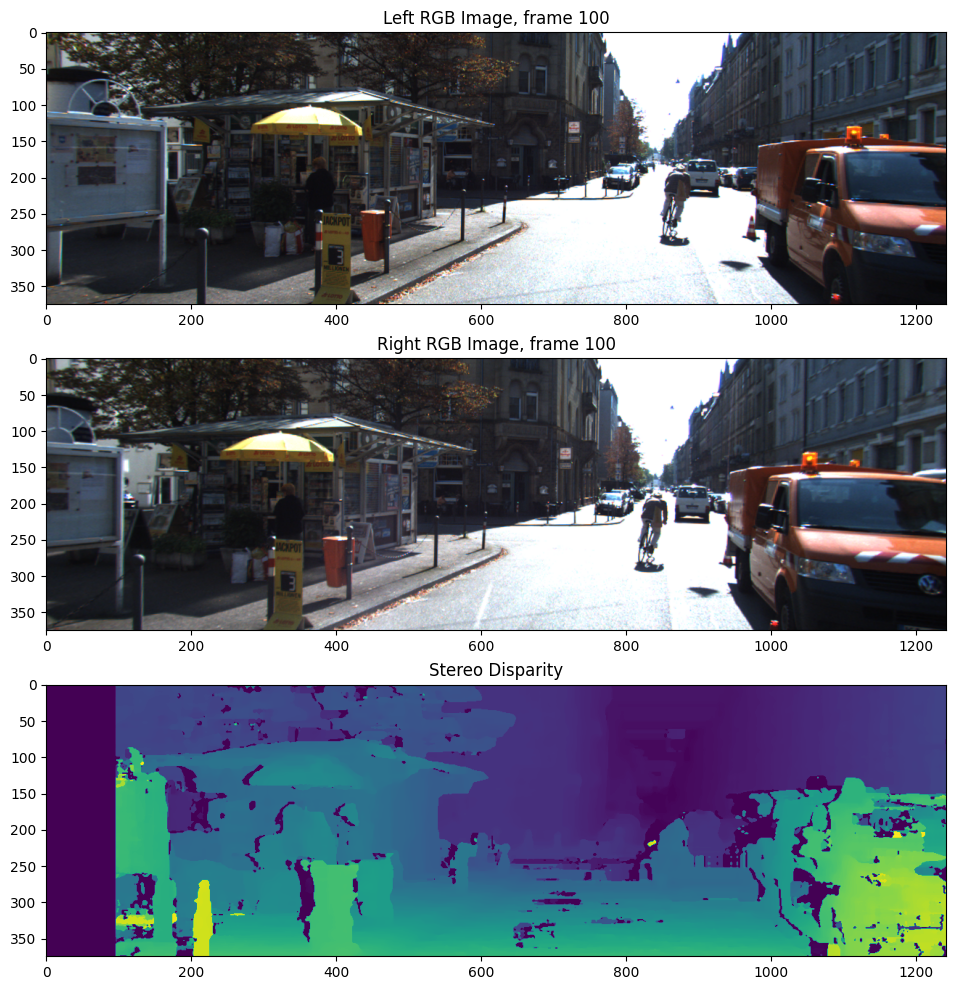

In [23]:
f, ax = plt.subplots(3, 1, figsize=(12,12))
ax[0].imshow(left_rgb)#, cmap='gray')
ax[0].set_title('Left RGB Image, frame %d' %idx)

ax[1].imshow(right_rgb) #, cmap='gray')
ax[1].set_title('Right RGB Image, frame %d' %idx)

ax[2].imshow(disparity) # cmap='viridis'
ax[2].set_title('Stereo Disparity')

plt.show()

# < stereodemo >

python package for comparing outputs of various deep learning-based stereo depth estimation methods

In [24]:
# %%bashf
# %stereodemo

In [25]:
# # get depth image from KITTI-CARLA
# idx = 1000
# prefix = '/home/derm/KITTICARLA/dataset/Town03/generated/images_depth'
# fn = prefix + '/' + "%04d" %idx + '_21.png'
# # print(fn)
# d = cv2.imread(fn)
# fig, ax = plt.subplots()
# ax.imshow(d)


# Convert Disparity to Depth Map
https://medium.com/swlh/camera-lidar-projection-navigating-between-2d-and-3d-911c78167a94


https://github.com/darylclimb/cvml_project/blob/master/projections/lidar_camera_projection/utils.py

In [26]:
def project_cam2_to_velo(calib):
    R_ref2rect = np.eye(4)
    R0_rect = calib['R0_rect'].reshape(3, 3)  # ref_cam2rect
    R_ref2rect[:3, :3] = R0_rect
    R_ref2rect_inv = np.linalg.inv(R_ref2rect)  # rect2ref_cam

    # inverse rigid transformation
    velo2cam_ref = np.vstack((calib['Tr_velo_to_cam'].reshape(3, 4), np.array([0., 0., 0., 1.])))  # velo2ref_cam
    P_cam_ref2velo = np.linalg.inv(velo2cam_ref)

    proj_mat = P_cam_ref2velo @ R_ref2rect_inv
    return proj_mat

def read_calib_file(filepath):
    """
    Read in a calibration file and parse into a dictionary.
    Ref: https://github.com/utiasSTARS/pykitti/blob/master/pykitti/utils.py
    """
    data = {}
    with open(filepath, 'r') as f:
        for line in f.readlines():
            line = line.rstrip()
            if len(line) == 0: continue
            key, value = line.split(':', 1)
            # The only non-float values in these files are dates, which
            # we don't care about anyway
            try:
                data[key] = np.array([float(x) for x in value.split()])
            except ValueError:
                pass

    return data

# calib = read_calib_file("/media/derm/06EF-127D3/KITTI/2011_09_26/calib_cam_to_cam.txt") #calibration text file
# calib = read_calib_file('000114_calib.txt')
calib = read_calib_file('/home/daniel-choate/Datasets/KITTI/2011_09_26/calib_cam_to_cam.txt')
# print(calib.keys())

Q = project_cam2_to_velo(calib)
print(Q)

KeyError: 'R0_rect'

# Intrinsic Matrix 

http://ksimek.github.io/2013/08/13/intrinsic/

https://towardsdatascience.com/inverse-projection-transformation-c866ccedef1c

Convert between pixel coordinates (u, v) and xyz

$$\mathbf{K} =
\begin{bmatrix}
f_x & S & c_x \\
0 & f_y & c_y \\
0 & 0 & 1
\end{bmatrix}
$$

$$
S = \text{skew factor (usually 0)}
$$

$$ f_x , f_y  = \text{focal length in x and y}$$

$$ c_x , c_y  = \text{principal point: pixel center locations in x and y}$$

$$
\begin{bmatrix}
u \\
v \\
1
\end{bmatrix}
= \frac{1}{z} K [R | t]
\begin{bmatrix}
x \\
y \\
z \\
1
\end{bmatrix}
$$

# Extrinsic Matrix

Transformation that relates the coordinate frames of different sensors

(i.e. LIDAR -> FLIR)

$$
[R | t]
$$

In [ ]:
# import open3d as o3d

# rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(color, depth_as_img, convert_rgb_to_intensity = False)

# rgbd = np.array(left_rgb)
# rgbd = np.append(rgbd, depth[:,:,None], axis = -1)
# # print(np.shape(depth))
# print(np.shape(rgbd))

# pinhole_camera_intrinsic = o3d.camera.PinholeCameraIntrinsic
# pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, pinhole_camera_intrinsic)


In [ ]:
#get depth
baseline = 0.54 #(m)
focal = 712 # pixels
scale = 1242
# disparity[disparity == 0] = -1 #remove zeros
# depth = baseline * focal / (disparity * scale)
test = np.max(disparity) - disparity
test[test == 0] = -1
depth = baseline * focal / (test * scale)

#project image to 3d
t_cam_velo = dataset.calib.T_cam0_velo_unrect
r_rect = dataset.calib.R_rect_00
p_rect = dataset.calib.P_rect_30
pts3dcam = r_rect @ t_cam_velo

Q = t_cam_velo #nope
# print(Q)
test = dataset.calib.P_rect_00 
# print(test)

# #according to ChatGPT:
# f_x = 7.215377e+02
# c_x = 6.095593e+02
# s_x = 1.0
# f_y = 7.215377e+02   # vertical focal length in pixels
# c_y = 1.728540e+02   # principal point in the y-direction in pixels
# s_y = 1.0            # vertical pixel size
# Q = np.array([[f_x / s_x, 0,         c_x, -c_x/ s_x],
#               [0,         f_y / s_y, c_y, -c_y / s_y],
#               [0,         0,         1,   0],
#               [0,         0,         0,   1]])

# print(Q)
# print(np.shape(disparity))
# print(disparity)
# print(depth)
test = cv2.reprojectImageTo3D(disparity, Q)
# print(cv2.reprojectImageTo3D.__doc__)
# print(np.shape(test))
# print(test)
# test = np.transpose(test, [1,0,2])
pc = np.reshape(test, [-1,3])
# test = test[:,[0,2,1]]



In [ ]:
def depth2xyz(img):
#     P_rect = (intrinsic matrix) * (extrinsic matrix)
#      y = P_rect * x
#      y = (u, v, 1).T 
#      x = ( x, y, z, 1)T

#     Extrinsic Matrix:
#     calib_velo_to_cam.txt: Velodyne-to-camera registration
#     R = np.array([[9.999976e-01, 7.553071e-04, -2.035826e-03],
#                   [-7.854027e-04, 9.998898e-01, -1.482298e-02],
#                   [2.024406e-03, 1.482454e-02, 9.998881e-01]])
#     T = np.array([[-8.086759e-01, 3.195559e-01, -7.997231e-01]]).T
    
#     print(R)
#     print(T)
    
#     P_rect = dataset.calib.P_rect_00
    pc = np.zeros([np.shape(img)[0] * np.shape(img)[1] , 3])
#     print(np.shape(img))
#     print(np.shape(pc))
    f_x = 7.215377e+02
    c_x = np.shape(depth)[1]//2 #6.095593e+02
    s_x = 1. #1.0
    f_y = 7.215377e+02   # vertical focal length in pixels
    c_y = np.shape(depth)[0]//2 #1.728540e+02   # principal point in the y-direction in pixels
    s_y = 1. #1.0            # vertical pixel size
    Q = np.array([[f_x / s_x, 0,         c_x, -c_x/ s_x],
                  [0,         f_y / s_y, c_y, -c_y / s_y],
                  [0,         0,         1,   0],
                  [0,         0,         0,   1]])     
#     Q = np.array([[1/f_x,     0,     0, 0],
#                   [0,         1/f_y, 0, 0],
#                   [0,         0,     1, 0],
#                   [0,         0,     0, 1]]) 
    
#     print(Q)
    Q = dataset.calib.P_rect_00
    print(Q)


    print(np.shape(img))
    count = 0
    for x in range(np.shape(img)[1]):
        for y in range(np.shape(img)[0]):         

            pc[count, 0] = (x - c_x) * img[y,x] / f_x
            pc[count, 1] = (y - c_y) * img[y,x] / f_y    
            pc[count, 2] = img[y,x]
            count += 1
                
#     pc[:,0] = pc[:,0]*0.001
#     pc[:,1] = pc[:,1]*0.001
    return pc

# pc = depth2xyz(depth)
# pc = depth2xyz(-abs(depth))
# print(disparity[100:,100:])
# pc = depth2xyz(disparity)
test = np.max(disparity) - disparity
pc = depth2xyz(test)
# # print(pc)
# print(np.shape(depth))

In [ ]:
#TODO: rectify barrel distortion in raw KITTI images
P = dataset.calib.P_rect_00
print(P)

def depth2xyz(depth):
    height, width = np.shape(depth)
#     print(height, width)    
    xyz = np.zeros([height*width, 3])
#     print(np.shape(xyz))
    u0 = width // 2
    v0 = height //2
    fx = 721.5
    fy = 721.5
        
    count = 0
    for v in range(height):
        for u in range(width):
            
            x = (u - u0) * depth[v, u] / fx
            y = (v - v0) * depth[v, u] / fy
            z = depth[v, u] #gt
            xyz[count] = (x,z,-y)
            
            #TODO: don't add points in with no depth return
            
            count += 1
    
    return xyz

temp = np.max(disparity) - disparity
pc = depth2xyz(temp)
# pc = depth2xyz(disparity)
# print(np.shape(disparity))

In [ ]:
plt1 = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #ax = 4
disp = []
# cmap = 'red'
# cmap = np.array([pc[:,0], 1 - pc[:,0], pc[:,0]]).T.tolist()

cmap = np.reshape(np.array(left_rgb), [-1,3]).tolist()
# print(np.shape(cmap))
disp.append(Points(pc, c = cmap, r = 5, alpha = 1))
disp.append(Points([[0,0,0]], c = 'purple', r = 10, alpha = 1)) #draw origin
plt1.show(disp, "Stereo Vision to Point Cloud Test")
ViewInteractiveWidget(plt1.window)